## Generate client_data_mapping

In [2]:
# -*- coding: utf-8 -*-
import os
import csv
import json
import pickle
import random
from pathlib import Path
from collections import defaultdict, OrderedDict, Counter

import numpy as np

# -------------------------------
# Config (edit here if needed)
# -------------------------------
DATASET_ROOT = Path("/Data/baptiste.geisenberger/Data/openImg")
SPLITS = ["train", "validation", "test"]  # folders that exist under DATASET_ROOT
OUTPUT_DIR = DATASET_ROOT / "client_data_mapping"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Paths relative to the *notebook* location
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

# Use the first N old client IDs, remapped to new IDs 0..N-1
N_CLIENTS = 12640

# Train floor per client, enforced per cluster on the train split
TRAIN_FLOOR = 32

# Random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# -------------------------------
# Label-skew controls (alpha sliders in [0,1])
# -------------------------------
# ALPHA_*_FRAC are the user-facing sliders:
#  - 0.0 -> very spiky (not close at all to base)
#  - 1.0 -> very smooth (very close to base)
ALPHA_CLUSTER_FRAC = 0.05     # closeness of cluster distributions to the global label distribution
ALPHA_CLIENT_FRAC  = 0.2     # closeness of client distributions to their cluster distribution

# We map these sliders to Dirichlet TOTAL concentration using label-aware scaling:
# total_alpha = (per_label_alpha) * L, where L = number of labels.
# per_label_alpha is log-interpolated in [ALPHA_PER_LABEL_MIN, ALPHA_PER_LABEL_MAX]:
#   frac=0 -> per_label_alpha = ALPHA_PER_LABEL_MIN  (very spiky)
#   frac=1 -> per_label_alpha = ALPHA_PER_LABEL_MAX  (very smooth / near base)
ALPHA_PER_LABEL_MIN = 0.01   # extremely spiky
ALPHA_PER_LABEL_MAX = 10.0   # very smooth

# -------------------------------
# Cluster size skew by rank
# -------------------------------
# Order clusters by descending "rank". Assign decreasing per-client averages via a linear schedule:
#   s_k = 1 - GAMMA * (pos / (K-1)), where pos=0 for highest-rank cluster.
# Larger GAMMA -> steeper drop from the highest-rank to lowest-rank cluster.
GAMMA_CLUSTER_LINEAR = 0.3

# Heavy-tailed size distribution parameters (lognormal), same for all clusters
LOGNORM_MU   = 0.0
LOGNORM_SIG  = 1.0

# File extension filter
EXTENSIONS = {".jpg", ".jpeg", ".JPG", ".JPEG"}

# -------------------------------
# Helpers
# -------------------------------

def extract_label_from_filename(fname: str) -> str:
    base = os.path.basename(fname)
    stem, _ = os.path.splitext(base)
    if "___" not in stem:
        raise ValueError(f"Filename does not contain '___': {fname}")
    after = stem.split("___", 1)[1]
    return after if after.startswith("_") else "_" + after

def list_images_by_split(dataset_root: Path, splits):
    result = {}
    for split in splits:
        split_dir = dataset_root / split
        if not split_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {split_dir}")
        files = []
        for p in split_dir.iterdir():
            if p.is_file() and p.suffix in EXTENSIONS:
                rel_path = f"{split}/{p.name}"
                label = extract_label_from_filename(p.name)
                files.append((rel_path, label))
        if not files:
            raise RuntimeError(f"No images found in {split_dir} with extensions {EXTENSIONS}")
        result[split] = files
    return result

def load_clusters_and_clients(clusters_json_path: Path, clients_pkl_path: Path, n_clients: int):
    with open(clusters_json_path, "r") as f:
        clusters = json.load(f)

    # Build (id -> rank) and model->cluster_id maps
    cluster_rank = {}
    model_to_cluster = {}
    for c in clusters:
        cid = int(c["id"])
        cluster_rank[cid] = float(c.get("rank", 0))
        for m in c.get("models", []):
            if m in model_to_cluster and model_to_cluster[m] != cid:
                raise ValueError(f"Model '{m}' appears in multiple clusters ({model_to_cluster[m]} and {cid})")
            model_to_cluster[m] = cid

    with open(clients_pkl_path, "rb") as f:
        clients_obj = pickle.load(f)

    entries = []
    if isinstance(clients_obj, (dict, OrderedDict)):
        for v in clients_obj.values():
            cid = int(v["id"]) if "id" in v else None
            if cid is None:
                raise RuntimeError("clients.pkl entry missing 'id'.")
            entries.append({"id": cid, "model": v["model"]})
    elif isinstance(clients_obj, (list, tuple)):
        for v in clients_obj:
            entries.append({"id": int(v["id"]), "model": v["model"]})
    else:
        raise TypeError(f"Unsupported clients.pkl type: {type(clients_obj)}")

    entries.sort(key=lambda x: x["id"])
    if len(entries) < n_clients:
        raise ValueError(f"Requested {n_clients} clients but clients.pkl has only {len(entries)}")

    selected = entries[:n_clients]
    selected_client_ids = [e["id"] for e in selected]

    # Map selected clients -> clusters
    missing = []
    client_id_to_cluster = {}
    cluster_id_to_clients_oldids = defaultdict(list)
    for e in selected:
        oid = e["id"]
        model = e["model"]
        if model not in model_to_cluster:
            missing.append((oid, model))
        else:
            k = model_to_cluster[model]
            client_id_to_cluster[oid] = k
            cluster_id_to_clients_oldids[k].append(oid)

    if missing:
        sample = "\n".join([f"  old_id={cid} model='{m}'" for cid, m in missing[:20]])
        more = "" if len(missing) <= 20 else f"\n  ... and {len(missing)-20} more"
        raise RuntimeError("Some selected clients have models not in clusters.json.\n" + sample + more)

    # Remap old IDs -> new IDs [0..N-1]
    sorted_selected = sorted(selected_client_ids)
    old2new = {old: i for i, old in enumerate(sorted_selected)}
    new2old = {i: old for old, i in old2new.items()}

    # Remap cluster maps to NEW ID space
    client2cluster_newid = {old2new[oid]: client_id_to_cluster[oid] for oid in selected_client_ids}
    cluster2clients_newid = defaultdict(list)
    for nid, k in client2cluster_newid.items():
        cluster2clients_newid[k].append(nid)

    return (selected_client_ids, old2new, new2old,
            client2cluster_newid, cluster2clients_newid,
            cluster_rank)

def build_label_vocab(split_files: dict):
    labels = set()
    for split, files in split_files.items():
        for _, label in files:
            labels.add(label)
    label_list = sorted(labels)
    label_to_id = {lbl: i for i, lbl in enumerate(label_list)}
    id_to_label = {i: lbl for lbl, i in label_to_id.items()}

    pools = {}
    for split, files in split_files.items():
        lab2paths = defaultdict(list)
        for rel_path, label in files:
            lab2paths[label].append(rel_path)
        for lab in lab2paths:
            random.shuffle(lab2paths[lab])
        pools[split] = lab2paths
    return label_to_id, id_to_label, pools

def normalize_counts_to_total(raw_sizes, total, floor=0):
    n = len(raw_sizes)
    if floor * n > total:
        raise ValueError(f"Cannot satisfy floor={floor} with n={n} and total={total}")
    remaining = total - floor * n
    w = np.array(raw_sizes, dtype=float)
    w = np.maximum(w, 1e-12)
    w /= w.sum()
    alloc = (w * remaining).astype(int)
    residual = remaining - int(alloc.sum())
    if residual > 0:
        fracs = (w * remaining) - np.floor(w * remaining)
        order = np.argsort(-fracs)
        for idx in order[:residual]:
            alloc[idx] += 1
    alloc += floor
    delta = total - int(alloc.sum())
    if delta != 0:
        sign = 1 if delta > 0 else -1
        for i in range(abs(delta)):
            alloc[i % n] += sign
    assert int(alloc.sum()) == total
    return alloc.tolist()

def sample_client_sizes(n_clients, total_images, floor, mu=0.0, sigma=1.0):
    raw = np.random.lognormal(mean=mu, sigma=sigma, size=n_clients)
    return normalize_counts_to_total(raw, total_images, floor=floor)

def map_alpha_total(frac: float, num_labels: int) -> float:
    """Map slider in [0,1] to Dirichlet TOTAL concentration, label-aware."""
    # Geometric/log interpolation gives a perceptually smoother slider
    per_label = (ALPHA_PER_LABEL_MIN ** (1.0 - frac)) * (ALPHA_PER_LABEL_MAX ** frac)
    return float(per_label * max(1, num_labels))

def dirichlet_from_base(base_probs, alpha_total):
    """Draw a distribution from Dirichlet(alpha_total * base). alpha_total is TOTAL concentration."""
    base = np.array(base_probs, dtype=float)
    base = base / base.sum()
    params = np.maximum(alpha_total * base, 1e-12)
    return np.random.dirichlet(params)

def js_divergence(p, q, eps=1e-12):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = np.maximum(p, eps); p /= p.sum()
    q = np.maximum(q, eps); q /= q.sum()
    m = 0.5*(p+q)
    def kl(a, b): return np.sum(a * (np.log(a) - np.log(b)))
    return 0.5*kl(p, m) + 0.5*kl(q, m)

# -------------------------------
# Main
# -------------------------------

# 1) Load clients/clusters and build mappings
(selected_client_ids, old2new, new2old,
 client2cluster_newid, cluster2clients_newid,
 cluster_rank) = load_clusters_and_clients(CLUSTERS_JSON, CLIENTS_PKL, N_CLIENTS)

print(f"Selected clients (new id space): 0..{N_CLIENTS-1}")
print(f"Example mapping: old_id={min(selected_client_ids)} -> new_id=0, cluster={client2cluster_newid[0]}")

# 2) Scan dataset & build label vocabulary and pools
split_files = list_images_by_split(DATASET_ROOT, SPLITS)
label_to_id, id_to_label, split_label_pools = build_label_vocab(split_files)
L = len(label_to_id)
print(f"Discovered {L} unique labels across all splits.")

# Global hist per split + combined base
global_hist = {}
for split in SPLITS:
    cnt = Counter(lbl for _, lbl in split_files[split])
    vec = np.zeros(L, dtype=float)
    for lbl, c in cnt.items():
        vec[label_to_id[lbl]] = c
    global_hist[split] = vec
    print(f"{split}: {int(vec.sum())} images, {np.count_nonzero(vec)} labels present")

global_total_by_split = {s: int(v.sum()) for s, v in global_hist.items()}
combined_vec = sum(global_hist.values())
combined_total = int(combined_vec.sum())
combined_base = combined_vec / (combined_vec.sum() + 1e-12)
print(f"Combined total images: {combined_total}")

# 3) Compute cluster ordering by rank (desc), linear per-client averages, and quotas
clusters_present = sorted(cluster2clients_newid.keys())
K = len(clusters_present)
# Order clusters by descending rank (ties by cluster id)
ordered_clusters = sorted(clusters_present, key=lambda k: (-cluster_rank.get(k, 0), k))

# Linear schedule s_k over positions (0..K-1)
if K > 1:
    schedule = {ordered_clusters[pos]: 1.0 - GAMMA_CLUSTER_LINEAR * (pos / (K - 1)) for pos in range(K)}
else:
    schedule = {ordered_clusters[0]: 1.0}

# Per-cluster client counts and per-cluster "weight" = per-client average * n_k
n_k = {k: len(cluster2clients_newid[k]) for k in clusters_present}
w_k = {k: schedule[k] * n_k[k] for k in clusters_present}
sum_w = sum(w_k.values())
if sum_w <= 0:
    raise RuntimeError("Sum of cluster weights is zero.")

# For each split, derive cluster quotas from combined proportions (apply on each split total)
p_k = {k: w_k[k] / sum_w for k in clusters_present}  # fixed proportions across splits

def quota_per_split(split_total):
    raw = {k: p_k[k] * split_total for k in clusters_present}
    # Round while preserving total
    quotas = {k: int(np.floor(v)) for k, v in raw.items()}
    residual = split_total - sum(quotas.values())
    if residual > 0:
        fracs = sorted(((k, raw[k] - quotas[k]) for k in clusters_present), key=lambda x: -x[1])
        for i in range(residual):
            quotas[fracs[i % len(fracs)][0]] += 1
    return quotas  # sums to split_total

cluster_quota_by_split = {s: quota_per_split(global_total_by_split[s]) for s in SPLITS}

# Enforce TRAIN_FLOOR per client on train split by borrowing from other clusters
train_q = cluster_quota_by_split["train"].copy()
need_min = {k: TRAIN_FLOOR * n_k[k] for k in clusters_present}
deficit = {k: max(0, need_min[k] - train_q[k]) for k in clusters_present}
total_deficit = sum(deficit.values())
if total_deficit > 0:
    # Available surplus from clusters above their minimum
    surplus = {k: max(0, train_q[k] - need_min[k]) for k in clusters_present}
    total_surplus = sum(surplus.values())
    if total_surplus < total_deficit:
        raise RuntimeError("Not enough surplus to satisfy train floor per client across clusters.")
    # Borrow proportionally to surplus
    # Iterate until deficits are zero (handle integer effects)
    while total_deficit > 0:
        donors = [k for k in clusters_present if surplus[k] > 0]
        for dk in donors:
            if total_deficit == 0: break
            take = min(surplus[dk], max(1, total_deficit // max(1, len(donors))))
            train_q[dk] -= take
            surplus[dk] -= take
            total_deficit -= take
        # Give to deficit clusters in rank order (higher rank filled first is reasonable)
        receivers = [k for k in ordered_clusters if deficit[k] > 0]
        for rk in receivers:
            if total_deficit < 0: break
            can = min(deficit[rk], take if 'take' in locals() else 1)
            give = min(can, sum(surplus.values()) + total_deficit + 0)  # safe bound
            if give > 0:
                train_q[rk] += give
                deficit[rk] -= give
    # Commit adjusted train quotas
    cluster_quota_by_split["train"] = train_q

# 4) Build per-client sizes per split, within each cluster (lognormal heavy-tail)
split_client_sizes = {s: [0]*N_CLIENTS for s in SPLITS}

for s in SPLITS:
    quotas = cluster_quota_by_split[s]
    for k in clusters_present:
        client_list = cluster2clients_newid[k]
        quota = quotas[k]
        floor = TRAIN_FLOOR if s == "train" else 0
        if floor * len(client_list) > quota:
            # As a final guard (shouldn't happen after borrowing), clamp floor
            floor = quota // max(1, len(client_list))
        alloc = sample_client_sizes(len(client_list), quota, floor=floor, mu=LOGNORM_MU, sigma=LOGNORM_SIG)
        # Scatter into the full client vector
        for cid_local, size in enumerate(alloc):
            cid_global = client_list[cid_local]
            split_client_sizes[s][cid_global] = size

# Sanity: sums must match
for s in SPLITS:
    tot = sum(split_client_sizes[s])
    assert tot == global_total_by_split[s], f"{s} sizes sum {tot} != split total {global_total_by_split[s]}"

# 5) Sample cluster P_k and client q_i ONCE from combined base, reuse across splits
alpha_cluster_total = map_alpha_total(ALPHA_CLUSTER_FRAC, L)
alpha_client_total  = map_alpha_total(ALPHA_CLIENT_FRAC , L)

# Cluster distributions
cluster_P = {}
for k in clusters_present:
    cluster_P[k] = dirichlet_from_base(combined_base, alpha_cluster_total)

# Client distributions
client_q = {}
for cid in range(N_CLIENTS):
    k = client2cluster_newid[cid]
    client_q[cid] = dirichlet_from_base(cluster_P[k], alpha_client_total)

# 6) Assignment per split (draw without replacement; fill from most-available labels if needed)
def assign_split(split, label_pools, client_sizes, client_q_map, label_to_id):
    pools = {lab: paths[:] for lab, paths in label_pools.items()}
    remaining_per_label = {lab: len(paths) for lab, paths in pools.items()}
    total_available = sum(remaining_per_label.values())
    assert total_available == sum(client_sizes), "Client sizes must sum to total images in this split."

    rows = []
    label_ids = {lab: label_to_id[lab] for lab in pools.keys()}

    client_order = list(range(N_CLIENTS))
    random.shuffle(client_order)  # fair order across clusters

    def most_available_labels():
        return sorted((lab for lab in remaining_per_label if remaining_per_label[lab] > 0),
                      key=lambda x: -remaining_per_label[x])

    for cid in client_order:
        need = client_sizes[cid]
        if need == 0:
            continue
        q = client_q_map[cid]
        # q is already aligned to label_id order
        q_vec = np.array([q[lid] for lid in range(len(label_to_id))], dtype=float)
        q_vec = q_vec / (q_vec.sum() + 1e-12)

        desired = np.random.multinomial(need, q_vec)
        assigned = 0

        # First pass: follow desired, cap by availability
        desired_order = np.argsort(-desired)
        for lid in desired_order:
            if assigned >= need:
                break
            lab = id_to_label[lid]
            want = desired[lid]
            if want <= 0:
                continue
            have = remaining_per_label.get(lab, 0)
            take = min(want, have, need - assigned)
            for _ in range(take):
                sp = pools[lab].pop()
                rows.append([cid, sp, lab, lid])
            if take > 0:
                remaining_per_label[lab] -= take
                assigned += take

        # Second pass: fill leftovers from the most-available labels globally
        while assigned < need:
            avail = most_available_labels()
            if not avail:
                raise RuntimeError(f"Ran out of images while assigning split={split}, client={cid}")
            lab = avail[0]
            lid = label_ids[lab]
            sp = pools[lab].pop()
            remaining_per_label[lab] -= 1
            rows.append([cid, sp, lab, lid])
            assigned += 1

    leftover = sum(remaining_per_label.values())
    assert leftover == 0, f"Leftover images not assigned for split={split}: {leftover}"
    return rows

# Perform assignments
all_rows = {}
for split in SPLITS:
    rows = assign_split(
        split=split,
        label_pools=split_label_pools[split],
        client_sizes=split_client_sizes[split],
        client_q_map=client_q,
        label_to_id=label_to_id
    )
    rows.sort(key=lambda r: (r[0], r[1]))
    all_rows[split] = rows
    print(f"Assigned {len(rows)} rows for split '{split}'")

# 7) Write CSVs
for split in SPLITS:
    out_csv = OUTPUT_DIR / f"{split}.csv"
    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["client_id", "sample_path", "label_name", "label_id"])
        for cid, sp, lab, lid in all_rows[split]:
            writer.writerow([cid, sp, lab, lid])
    print(f"Wrote: {out_csv}")

# 8) Diagnostics (brief)
def summarize_sizes(vec):
    arr = np.array(vec, dtype=int)
    return {
        "min": int(arr.min()),
        "p10": int(np.percentile(arr, 10)),
        "median": int(np.median(arr)),
        "p90": int(np.percentile(arr, 90)),
        "max": int(arr.max()),
        "mean": float(arr.mean()),
        "std": float(arr.std()),
        "sum": int(arr.sum()),
        "num_clients_with_data": int((arr > 0).sum())
    }

for split in SPLITS:
    stats = summarize_sizes(split_client_sizes[split])
    print(f"\n[{split}] size stats:", stats)

# Within vs between-cluster JS (rough check, using combined client_q expectations)
clusters = ordered_clusters
cluster_means = {k: cluster_P[k] for k in clusters}
within = []
for k in clusters:
    idx = cluster2clients_newid[k]
    for cid in idx[:min(50, len(idx))]:
        within.append(js_divergence(client_q[cid], cluster_means[k]))
between = []
for i, ki in enumerate(clusters):
    for kj in clusters[i+1:]:
        between.append(js_divergence(cluster_means[ki], cluster_means[kj]))
if within:
    print(f"\nApprox. intra-cluster JS (lower is better): mean={float(np.mean(within)):.4f}")
if between:
    print(f"Approx. inter-cluster JS (higher is better): mean={float(np.mean(between)):.4f}")

print("\nDone. Point your FedScale config to:")
print(f"  data_map_file: {OUTPUT_DIR / 'train.csv'}")
print("Executor will detect n_real_clients from unique client_ids in train.csv.")

Selected clients (new id space): 0..12639
Example mapping: old_id=0 -> new_id=0, cluster=5
Discovered 596 unique labels across all splits.
train: 1452311 images, 596 labels present
validation: 63063 images, 561 labels present
test: 190135 images, 576 labels present
Combined total images: 1705509
Assigned 1452311 rows for split 'train'
Assigned 63063 rows for split 'validation'
Assigned 190135 rows for split 'test'
Wrote: /Data/baptiste.geisenberger/Data/openImg/client_data_mapping/train.csv
Wrote: /Data/baptiste.geisenberger/Data/openImg/client_data_mapping/validation.csv
Wrote: /Data/baptiste.geisenberger/Data/openImg/client_data_mapping/test.csv

[train] size stats: {'min': 33, 'p10': 46, 'median': 82, 'p90': 214, 'max': 2434, 'mean': 114.89802215189873, 'std': 108.05270322071219, 'sum': 1452311, 'num_clients_with_data': 12640}

[validation] size stats: {'min': 0, 'p10': 1, 'median': 3, 'p90': 11, 'max': 252, 'mean': 4.989161392405063, 'std': 6.688547712266763, 'sum': 63063, 'num_cli

## Analyse generated mapping

/tmp/ipykernel_300088/397667605.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/users/eleves-a/2024/baptiste.geisenberger/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


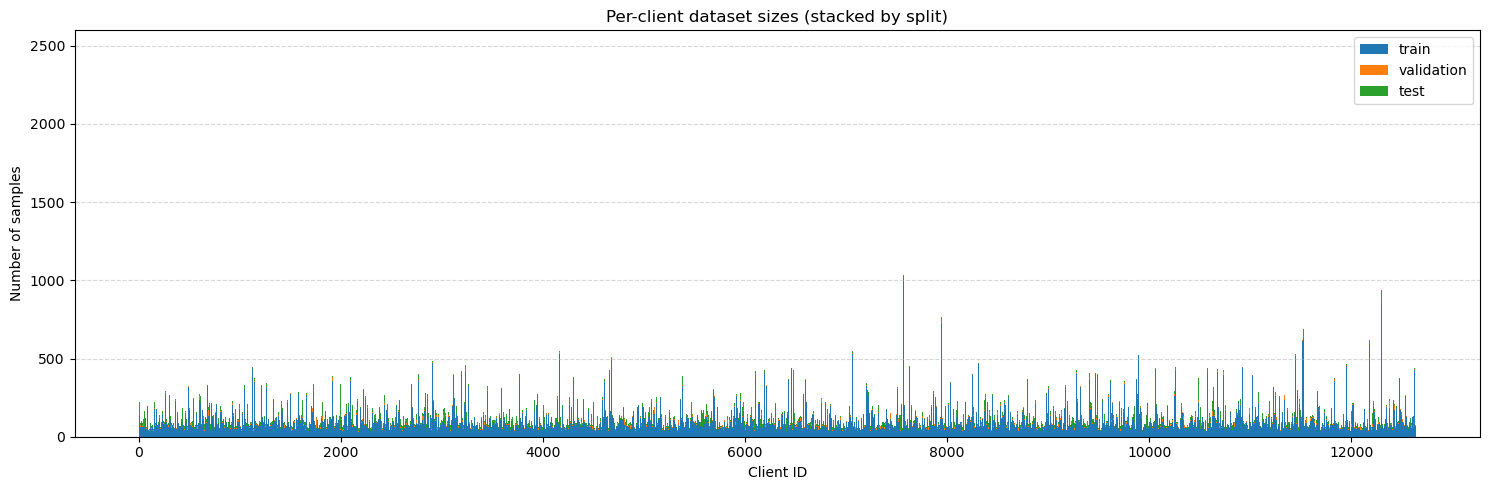

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
    "validation": MAPPING_DIR / "validation.csv",
    "test": MAPPING_DIR / "test.csv",
}

# -----------------------------
# Load counts
# -----------------------------
counts = {}
for split, path in CSV_FILES.items():
    df = pd.read_csv(path)
    counts[split] = df.groupby("client_id").size()

# Union of all client IDs across splits
all_client_ids = sorted(set().union(*[s.index for s in counts.values()]))

# Build stacked matrix: rows = clients, cols = splits
mat = np.zeros((len(all_client_ids), len(CSV_FILES)), dtype=int)
split_names = list(CSV_FILES.keys())
for j, split in enumerate(split_names):
    s = counts[split]
    for i, cid in enumerate(all_client_ids):
        if cid in s.index:
            mat[i, j] = s.loc[cid]

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(15, 5))
bottom = np.zeros(len(all_client_ids), dtype=int)
colors = {"train": "tab:blue", "validation": "tab:orange", "test": "tab:green"}

for j, split in enumerate(split_names):
    ax.bar(all_client_ids, mat[:, j], bottom=bottom,
           label=split, color=colors.get(split, None), width=1.0)
    bottom += mat[:, j]

ax.set_xlabel("Client ID")
ax.set_ylabel("Number of samples")
ax.set_title("Per-client dataset sizes (stacked by split)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


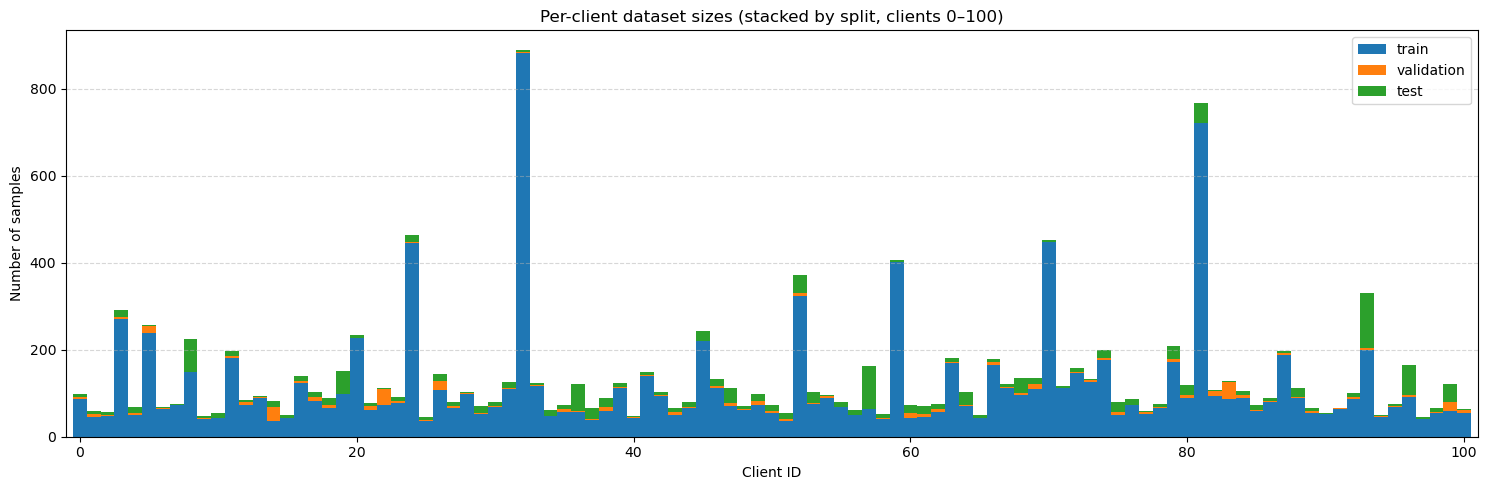

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
    "validation": MAPPING_DIR / "validation.csv",
    "test": MAPPING_DIR / "test.csv",
}

# -----------------------------
# Load counts
# -----------------------------
counts = {}
for split, path in CSV_FILES.items():
    df = pd.read_csv(path)
    counts[split] = df.groupby("client_id").size()

# Restrict to client IDs 0–100
client_range = list(range(0, 101))

# Build stacked matrix: rows = clients, cols = splits
mat = np.zeros((len(client_range), len(CSV_FILES)), dtype=int)
split_names = list(CSV_FILES.keys())
for j, split in enumerate(split_names):
    s = counts[split]
    for i, cid in enumerate(client_range):
        if cid in s.index:
            mat[i, j] = s.loc[cid]

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(15, 5))
bottom = np.zeros(len(client_range), dtype=int)
colors = {"train": "tab:blue", "validation": "tab:orange", "test": "tab:green"}

for j, split in enumerate(split_names):
    ax.bar(client_range, mat[:, j], bottom=bottom,
           label=split, color=colors.get(split, None), width=1.0)
    bottom += mat[:, j]

ax.set_xlim(-1, 101)  # make sure we see exactly 0–100
ax.set_xlabel("Client ID")
ax.set_ylabel("Number of samples")
ax.set_title("Per-client dataset sizes (stacked by split, clients 0–100)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


/tmp/ipykernel_300088/397796112.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))


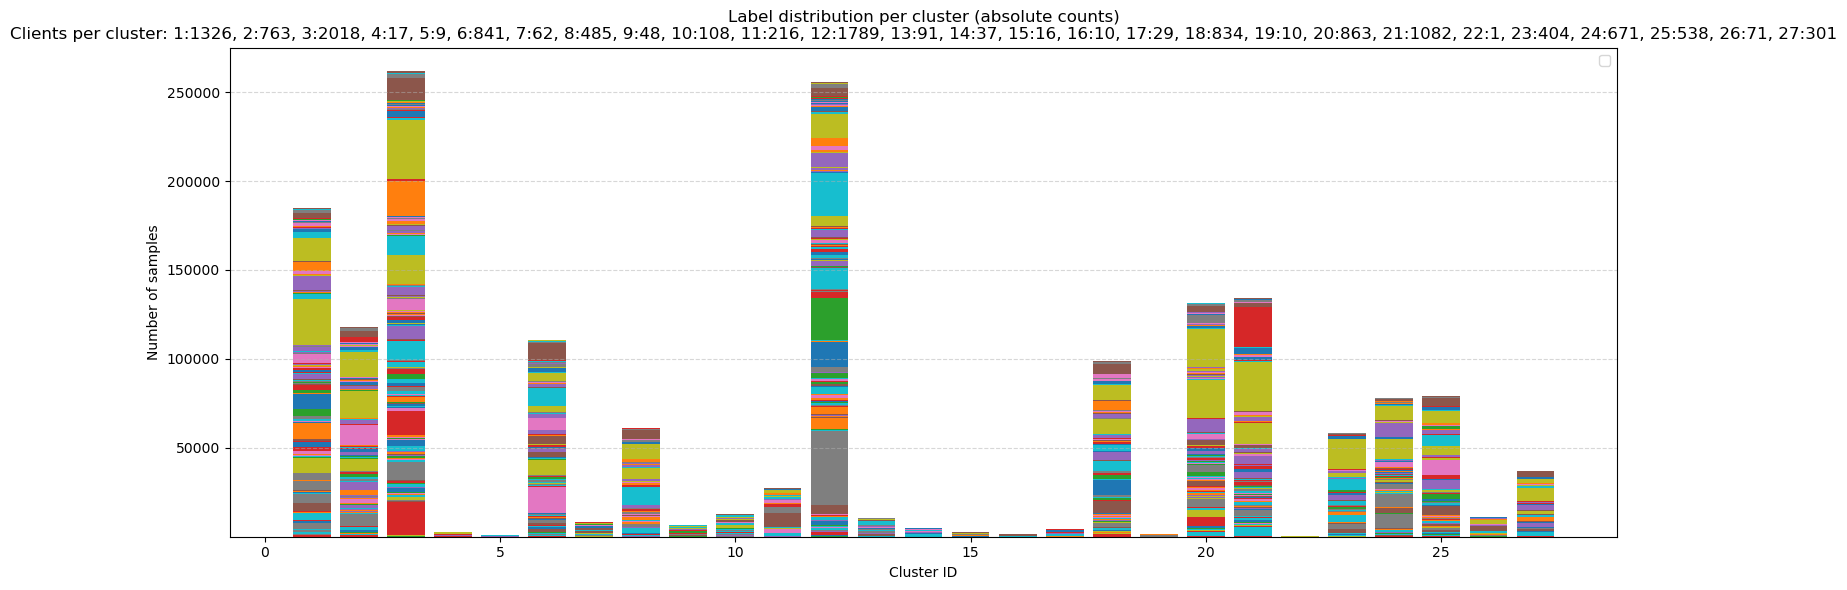

/tmp/ipykernel_300088/397796112.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))
/tmp/ipykernel_300088/397796112.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


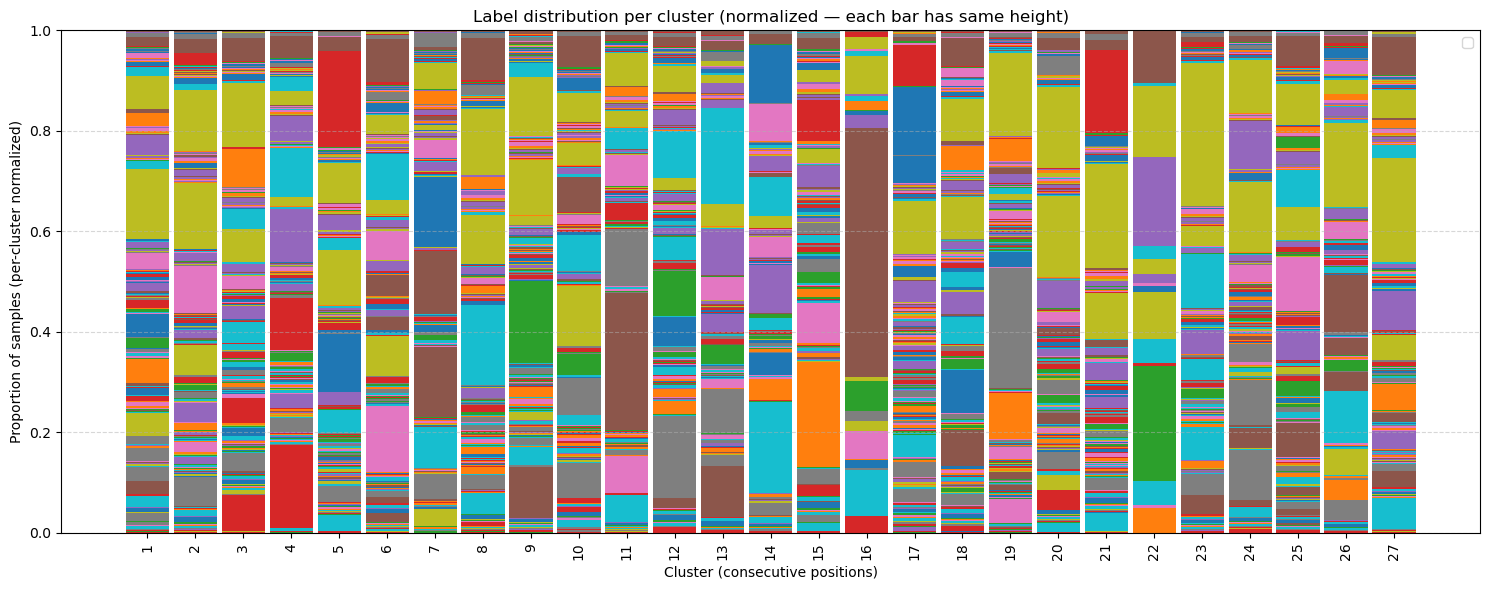

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
    "validation": MAPPING_DIR / "validation.csv",
    "test": MAPPING_DIR / "test.csv",
}
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

# -----------------------------
# Load partition data
# -----------------------------
df_all = []
for split, path in CSV_FILES.items():
    df = pd.read_csv(path)
    df["split"] = split
    df_all.append(df)
df = pd.concat(df_all, ignore_index=True)

# -----------------------------
# Load cluster mapping
# -----------------------------
with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)

model_to_cluster = {}
for c in clusters:
    for m in c["models"]:
        model_to_cluster[m] = c["id"]

with open(CLIENTS_PKL, "rb") as f:
    clients = pickle.load(f)

# Build client_id -> model
if isinstance(clients, dict):
    client_models = {int(v["id"]): v["model"] for v in clients.values()}
else:  # list-like
    client_models = {int(v["id"]): v["model"] for v in clients}

# Selected clients = those in CSVs
selected_clients = set(df["client_id"].unique())

# Build client_id -> cluster_id
client_to_cluster = {}
for cid in selected_clients:
    model = client_models[cid]
    if model not in model_to_cluster:
        raise RuntimeError(f"Model {model} (client {cid}) not found in clusters.json")
    client_to_cluster[cid] = model_to_cluster[model]

# -----------------------------
# Aggregate label counts per cluster
# -----------------------------
cluster_label_counts = defaultdict(Counter)
cluster_clients = defaultdict(set)

for _, row in df.iterrows():
    cid = int(row["client_id"])
    lab = row["label_name"]
    clus = client_to_cluster[cid]
    cluster_label_counts[clus][lab] += 1
    cluster_clients[clus].add(cid)

# All labels sorted for deterministic stacking
all_labels = sorted(df["label_name"].unique())

# -----------------------------
# Build DataFrame (clusters x labels)
# -----------------------------
clusters_sorted = sorted(cluster_label_counts.keys())
mat = []
for clus in clusters_sorted:
    counts = [cluster_label_counts[clus][lab] for lab in all_labels]
    mat.append(counts)
mat = pd.DataFrame(mat, index=clusters_sorted, columns=all_labels)

# -----------------------------
# 1) Absolute stacked bar chart
# -----------------------------
fig, ax = plt.subplots(figsize=(15, 6))
bottom = None
for lab in all_labels:
    vals = mat[lab].values
    ax.bar(clusters_sorted, vals, bottom=bottom, label=lab, width=0.8)
    if bottom is None:
        bottom = vals.copy()
    else:
        bottom = bottom + vals

ax.set_xlabel("Cluster ID")
ax.set_ylabel("Number of samples")
ax.set_title("Label distribution per cluster (absolute counts)\nClients per cluster: " +
             ", ".join(f"{c}:{len(cluster_clients[c])}" for c in clusters_sorted))
ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Normalized stacked bar chart (all bars same total height)
# -----------------------------
# Normalize each cluster row to sum==1 (if a cluster has zero total, keep zeros)
row_sums = mat.sum(axis=1).replace(0, 1)   # avoid division by zero
mat_norm = mat.div(row_sums, axis=0)

fig, ax = plt.subplots(figsize=(15, 6))
bottom = None
for lab in all_labels:
    vals = mat_norm[lab].values
    ax.bar(range(len(clusters_sorted)), vals, bottom=bottom, label=lab, width=0.9)
    if bottom is None:
        bottom = vals.copy()
    else:
        bottom = bottom + vals

# x ticks are consecutive indices; label them with cluster ids for reference
ax.set_xticks(range(len(clusters_sorted)))
ax.set_xticklabels(clusters_sorted, rotation=90)

ax.set_xlabel("Cluster (consecutive positions)")
ax.set_ylabel("Proportion of samples (per-cluster normalized)")
ax.set_title("Label distribution per cluster (normalized — each bar has same height)")
ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

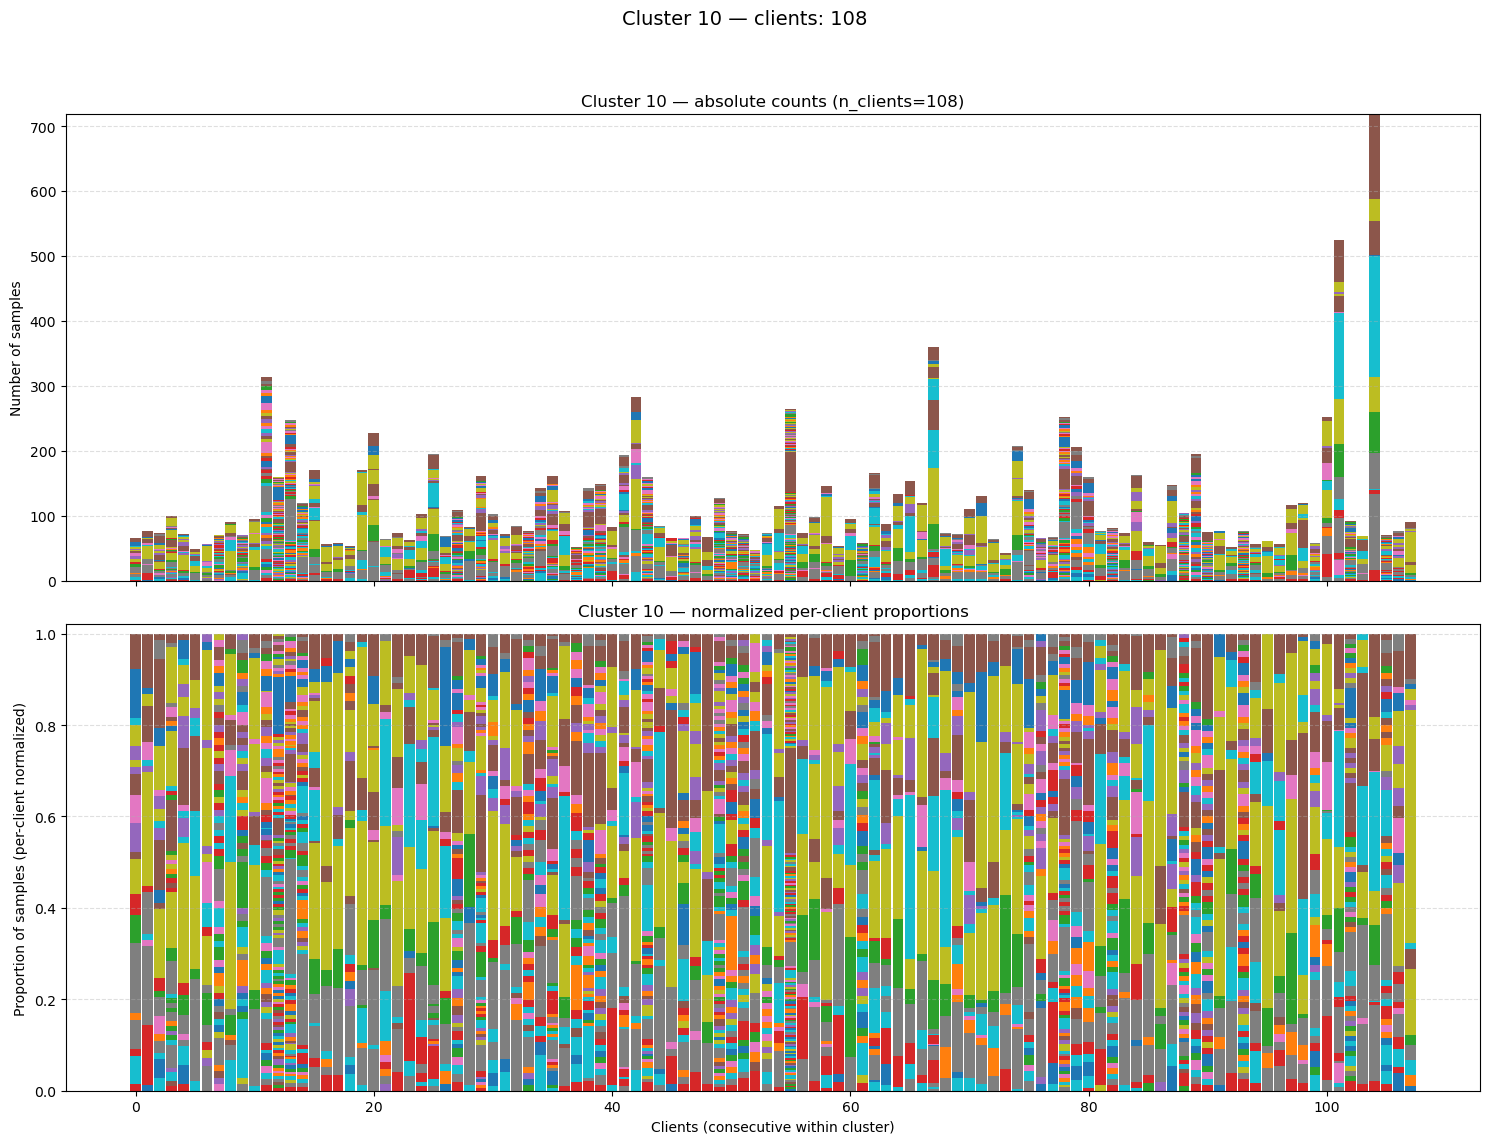

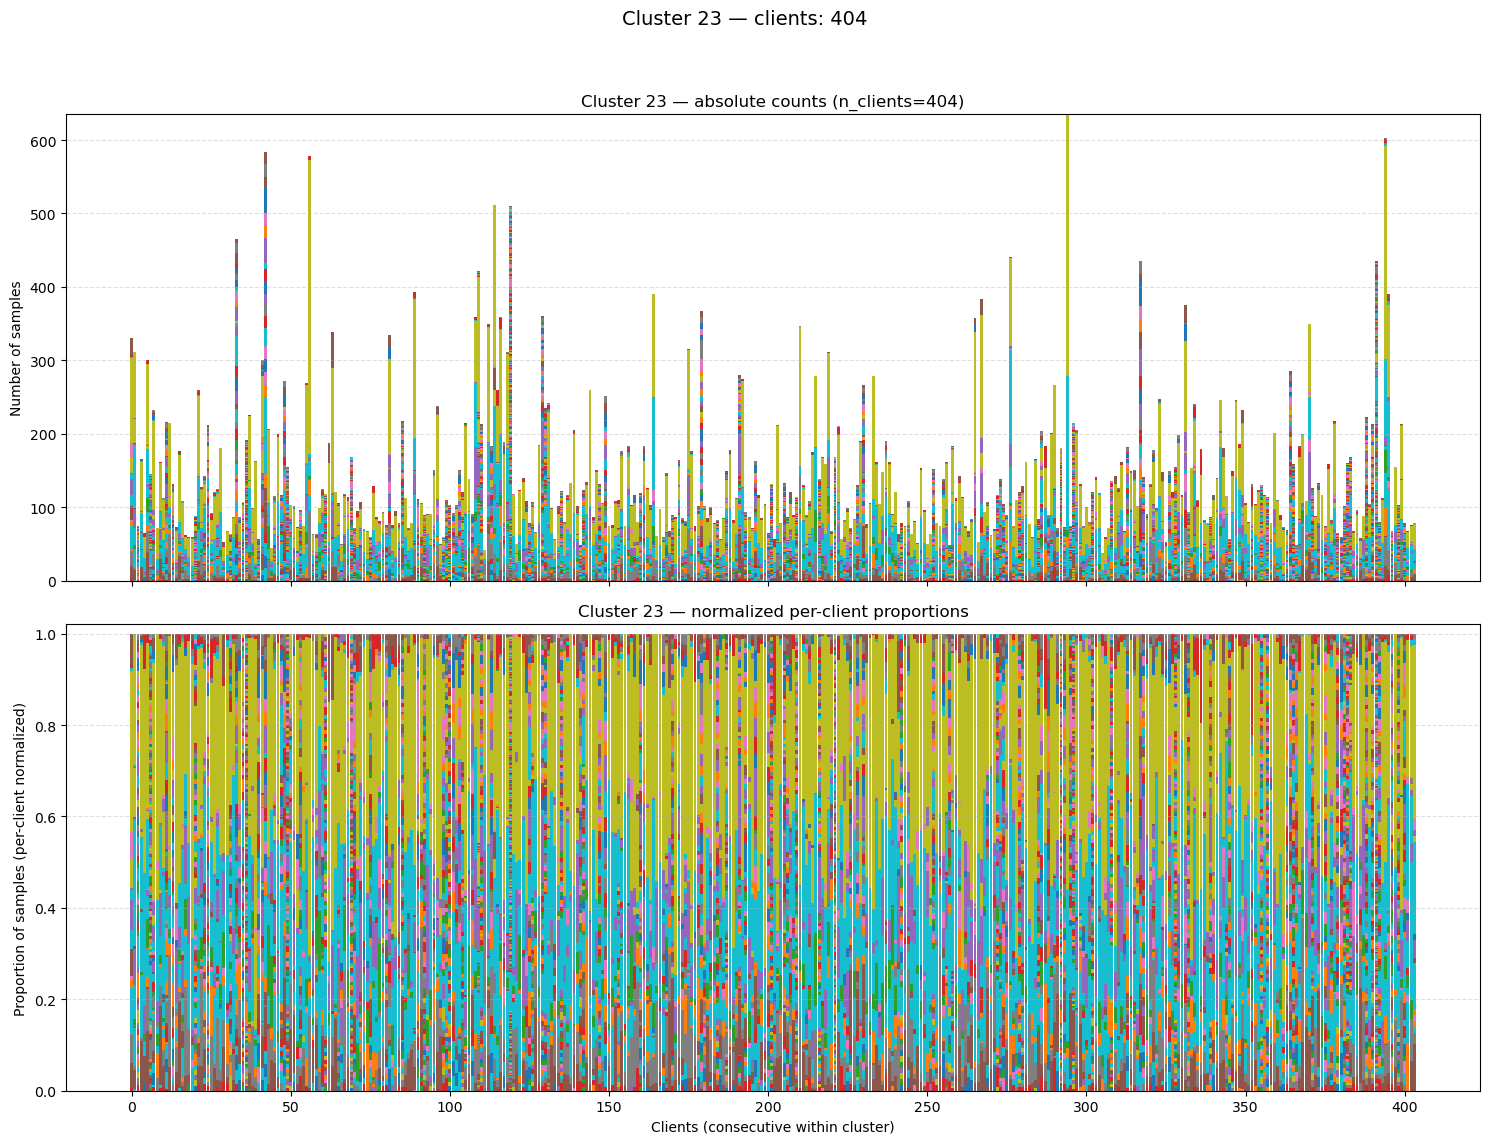

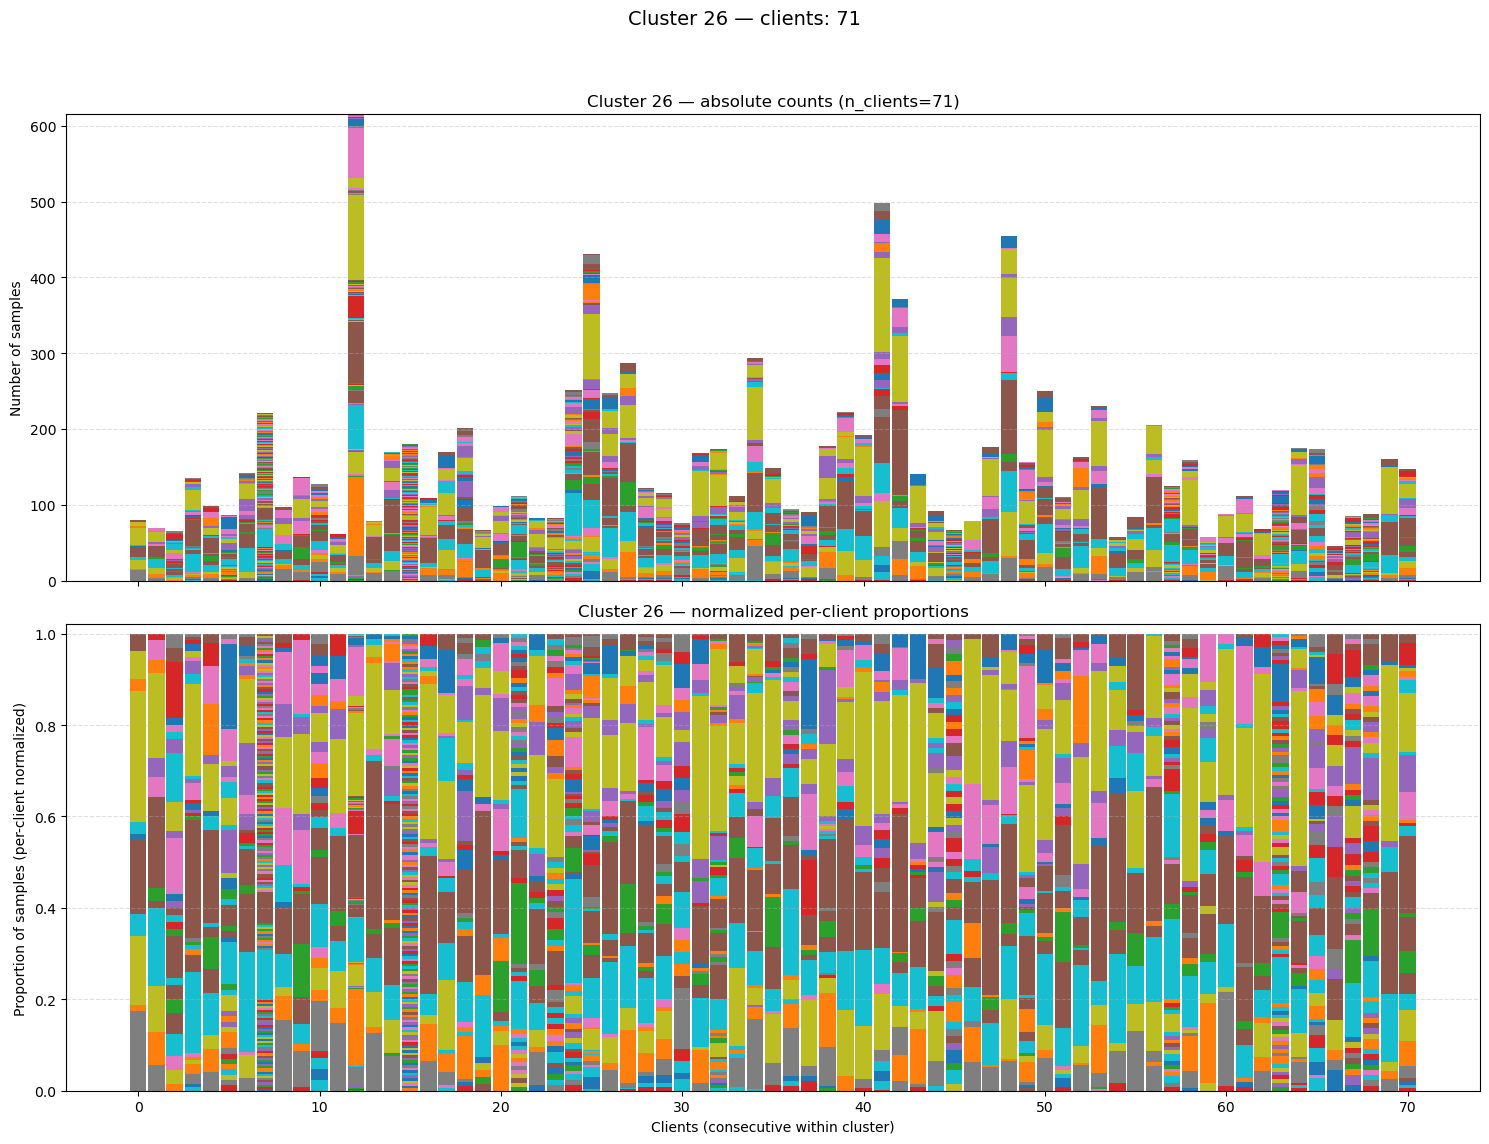

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
    "validation": MAPPING_DIR / "validation.csv",
    "test": MAPPING_DIR / "test.csv",
}
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

TARGET_CLUSTERS = [10, 23, 26]

# -----------------------------
# Load partition data
# -----------------------------
df_all = []
for split, path in CSV_FILES.items():
    df = pd.read_csv(path)
    df_all.append(df)
df = pd.concat(df_all, ignore_index=True)

# -----------------------------
# Load clusters and clients
# -----------------------------
with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)
model_to_cluster = {}
for c in clusters:
    for m in c.get("models", []):
        model_to_cluster[m] = c["id"]

with open(CLIENTS_PKL, "rb") as f:
    clients_obj = pickle.load(f)

entries = []
if isinstance(clients_obj, dict):
    for v in clients_obj.values():
        entries.append((int(v["id"]), v["model"]))
elif isinstance(clients_obj, (list, tuple)):
    for v in clients_obj:
        entries.append((int(v["id"]), v["model"]))
else:
    raise TypeError(f"Unsupported clients.pkl type: {type(clients_obj)}")

entries.sort(key=lambda t: t[0])
N = int(df["client_id"].max()) + 1
new2old = {i: entries[i][0] for i in range(N)}
oldid_to_model = {old: model for (old, model) in entries}

client_to_cluster = {}
for new_id in range(N):
    model = oldid_to_model[new2old[new_id]]
    if model not in model_to_cluster:
        raise RuntimeError(f"Model {model} not in clusters.json")
    client_to_cluster[new_id] = model_to_cluster[model]

# -----------------------------
# Aggregate label counts per client
# -----------------------------
client_label_counts = defaultdict(Counter)
for _, row in df.iterrows():
    cid = int(row["client_id"])
    lab = row["label_name"]
    client_label_counts[cid][lab] += 1

# -----------------------------
# Plot for target clusters (absolute above, normalized below)
# -----------------------------
labels = sorted(df["label_name"].unique())

for target_cluster in TARGET_CLUSTERS:
    # clients belonging to this cluster (consecutive index 0..M-1 used for plotting)
    cids = [cid for cid, clus in client_to_cluster.items() if clus == target_cluster]
    if not cids:
        print(f"No clients found for cluster {target_cluster}")
        continue

    # Build dataframe: rows = clients (consecutive index), cols = labels (absolute counts)
    mat_abs = []
    for cid in cids:
        mat_abs.append([client_label_counts[cid][lab] for lab in labels])
    mat_abs = pd.DataFrame(mat_abs, index=range(len(cids)), columns=labels)

    # Prepare normalized matrix: each row normalized to sum 1 (avoid division by zero)
    row_sums = mat_abs.sum(axis=1).replace(0, 1)  # keep zeros as zeros after division
    mat_norm = mat_abs.div(row_sums, axis=0)

    # Plot stacked vertically: absolute (top), normalized (bottom)
    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(15, 12), sharex=True,
                                         gridspec_kw={'height_ratios': [1, 1]})

    # --- Top: Absolute stacked bar chart ---
    bottom = None
    for lab in labels:
        vals = mat_abs[lab].values
        ax_top.bar(mat_abs.index, vals, bottom=bottom, label=lab, width=0.9)
        bottom = vals.copy() if bottom is None else bottom + vals
    ax_top.set_ylabel("Number of samples")
    ax_top.set_title(f"Cluster {target_cluster} — absolute counts (n_clients={len(cids)})")
    ax_top.grid(axis="y", linestyle="--", alpha=0.4)

    # --- Bottom: Normalized stacked bar chart (each client bar sums to 1) ---
    bottom = None
    x = list(range(len(cids)))
    for lab in labels:
        vals = mat_norm[lab].values
        ax_bot.bar(x, vals, bottom=bottom, label=lab, width=0.9)
        bottom = vals.copy() if bottom is None else bottom + vals
    ax_bot.set_xlabel("Clients (consecutive within cluster)")
    ax_bot.set_ylabel("Proportion of samples (per-client normalized)")
    ax_bot.set_ylim(0, 1.02)
    ax_bot.set_title(f"Cluster {target_cluster} — normalized per-client proportions")
    ax_bot.grid(axis="y", linestyle="--", alpha=0.4)

    # Legend handling: show only if label count small, else show top-10 labels by count
    if len(labels) <= 20:
        # show full legend below the bottom plot
        ax_bot.legend(ncol=4, bbox_to_anchor=(0.5, -0.35), loc="upper center")
    else:
        cluster_label_totals = mat_abs.sum(axis=0).sort_values(ascending=False)
        topk = cluster_label_totals.index[:10].tolist()
        handles, lablist = ax_bot.get_legend_handles_labels()
        lbl2h = dict(zip(lablist, handles))
        sel_handles = [lbl2h[l] for l in topk if l in lbl2h]
        if sel_handles:
            ax_bot.legend(sel_handles, topk, title="Top labels", bbox_to_anchor=(0.5, -0.35), loc="upper center")

    plt.suptitle(f"Cluster {target_cluster} — clients: {len(cids)}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

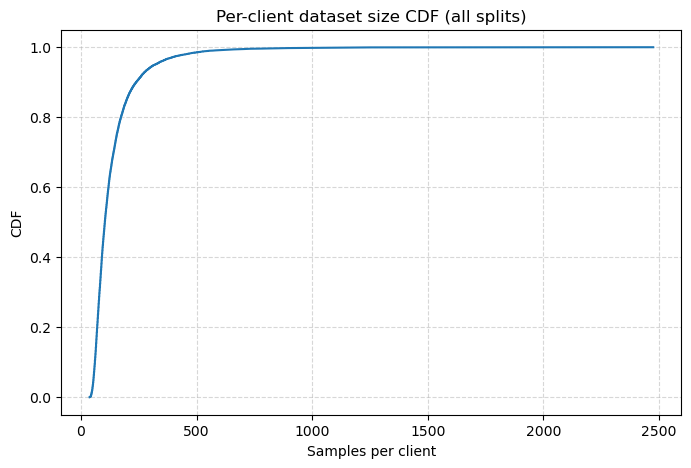

N clients with data: 12640, mean=134.9, std=110.4, p50=103, p90=239, p99=561


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

MAPPING_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
paths = [MAPPING_DIR/"train.csv", MAPPING_DIR/"validation.csv", MAPPING_DIR/"test.csv"]

df = pd.concat([pd.read_csv(p) for p in paths], ignore_index=True)
sizes = df.groupby("client_id").size().astype(int).sort_values().values

cdf_x = np.sort(sizes)
cdf_y = np.arange(1, len(cdf_x)+1) / len(cdf_x)

plt.figure(figsize=(8,5))
plt.plot(cdf_x, cdf_y)
plt.xlabel("Samples per client")
plt.ylabel("CDF")
plt.title("Per-client dataset size CDF (all splits)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

print(f"N clients with data: {len(sizes)}, mean={sizes.mean():.1f}, std={sizes.std():.1f}, "
      f"p50={np.percentile(sizes,50):.0f}, p90={np.percentile(sizes,90):.0f}, p99={np.percentile(sizes,99):.0f}")


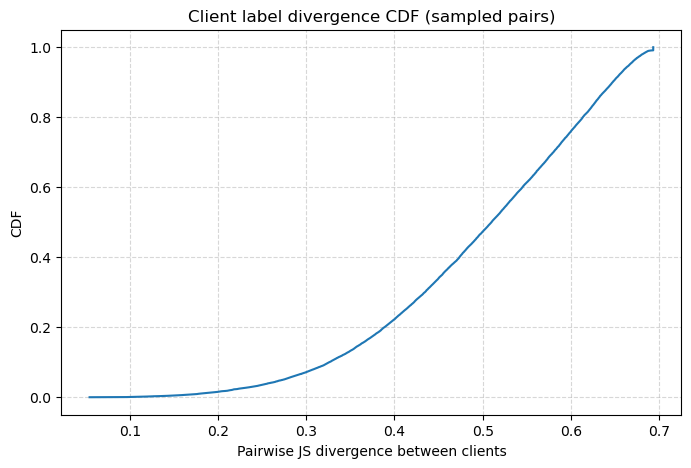

Pairs=19999 | JS: mean=0.496, median=0.510, p10=0.326, p90=0.647


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict, Counter
from itertools import combinations
import random

def js_divergence(p, q, eps=1e-12):
    p = np.maximum(p, eps); p /= p.sum()
    q = np.maximum(q, eps); q /= q.sum()
    m = 0.5*(p+q)
    def kl(a,b): return np.sum(a*(np.log(a)-np.log(b)))
    return 0.5*kl(p,m)+0.5*kl(q,m)

MAPPING_DIR = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
paths = [MAPPING_DIR/"train.csv", MAPPING_DIR/"validation.csv", MAPPING_DIR/"test.csv"]

df = pd.concat([pd.read_csv(p) for p in paths], ignore_index=True)
labels = sorted(df["label_name"].unique())
lid = {l:i for i,l in enumerate(labels)}
L = len(labels)

# Build client label distributions
g = df.groupby(["client_id","label_name"]).size().reset_index(name="cnt")
clients = sorted(g["client_id"].unique())
C = len(clients)

mat = np.zeros((C, L), dtype=float)
cid_index = {c:i for i,c in enumerate(clients)}
for _, row in g.iterrows():
    mat[cid_index[row["client_id"]], lid[row["label_name"]]] = row["cnt"]
mat = (mat.T / (mat.sum(axis=1)+1e-12)).T

# Sample pairs
random.seed(42)
MAX_PAIRS = 20000  # adjust if you want more/less precision
pairs = []
if C*(C-1)//2 <= MAX_PAIRS:
    pairs = list(combinations(range(C),2))
else:
    for _ in range(MAX_PAIRS):
        a, b = random.sample(range(C), 2)
        if a>b: a,b=b,a
        pairs.append((a,b))
    pairs = list(set(pairs))  # de-dup small chance

js_vals = np.array([js_divergence(mat[i], mat[j]) for i,j in pairs])
js_vals.sort()
cdf_y = np.arange(1, len(js_vals)+1)/len(js_vals)

plt.figure(figsize=(8,5))
plt.plot(js_vals, cdf_y)
plt.xlabel("Pairwise JS divergence between clients")
plt.ylabel("CDF")
plt.title("Client label divergence CDF (sampled pairs)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

print(f"Pairs={len(js_vals)} | JS: mean={js_vals.mean():.3f}, median={np.median(js_vals):.3f}, "
      f"p10={np.percentile(js_vals,10):.3f}, p90={np.percentile(js_vals,90):.3f}")


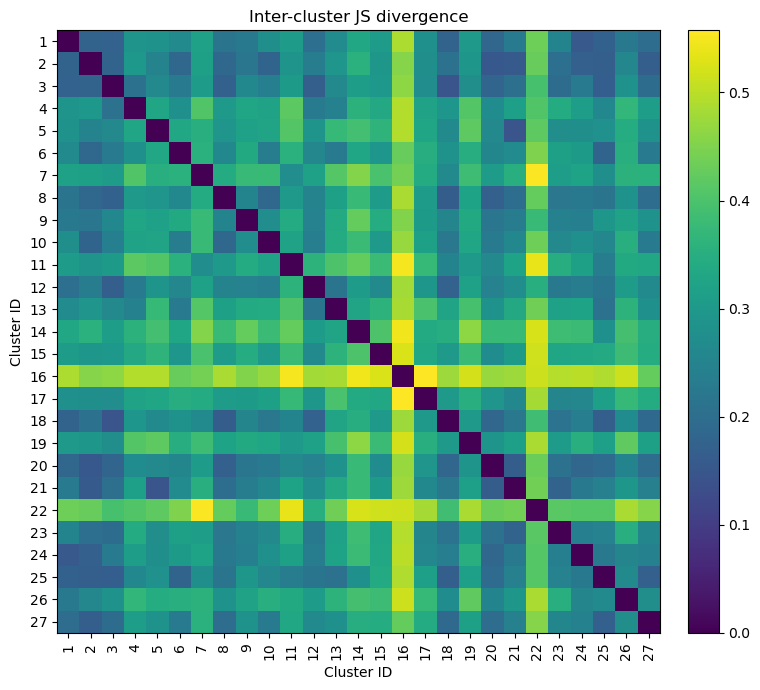

Inter-cluster JS: mean=0.312, median=0.304, min=0.146, max=0.557, pairs=351


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

def js_divergence(p, q, eps=1e-12):
    p = np.maximum(p, eps); p /= p.sum()
    q = np.maximum(q, eps); q /= q.sum()
    m = 0.5*(p+q)
    def kl(a,b): return np.sum(a*(np.log(a)-np.log(b)))
    return 0.5*kl(p,m)+0.5*kl(q,m)

MAPPING_DIR   = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

df = pd.concat([pd.read_csv(MAPPING_DIR/"train.csv"),
                pd.read_csv(MAPPING_DIR/"validation.csv"),
                pd.read_csv(MAPPING_DIR/"test.csv")], ignore_index=True)

# label ids
labels = sorted(df["label_name"].unique())
lid = {l:i for i,l in enumerate(labels)}
L = len(labels)

# Rebuild new_id -> cluster_id (same logic as earlier)
with open(CLUSTERS_JSON, "r") as f: clusters = json.load(f)
model_to_cluster = {m:c["id"] for c in clusters for m in c.get("models", [])}

with open(CLIENTS_PKL, "rb") as f: clients_obj = pickle.load(f)
entries = [(int(v["id"]), v["model"]) for v in (clients_obj.values() if isinstance(clients_obj, dict) else clients_obj)]
entries.sort(key=lambda t:t[0])
N = df["client_id"].max()+1
new2old = {i: entries[i][0] for i in range(N)}
old2model = dict(entries)
client_to_cluster = {i: model_to_cluster[old2model[new2old[i]]] for i in range(N) 
                     if old2model[new2old[i]] in model_to_cluster}

# Build cluster distributions
cluster_counts = defaultdict(lambda: np.zeros(L, dtype=float))
for _, r in df.iterrows():
    c = int(r["client_id"])
    if c not in client_to_cluster: continue
    k = client_to_cluster[c]
    cluster_counts[k][lid[r["label_name"]]] += 1

clusters_sorted = sorted(cluster_counts.keys())
P = {k: (v / (v.sum()+1e-12)) for k,v in cluster_counts.items()}

# Pairwise JS and heatmap
K = len(clusters_sorted)
mat = np.zeros((K,K), dtype=float)
for i, ki in enumerate(clusters_sorted):
    for j, kj in enumerate(clusters_sorted):
        if i==j: continue
        mat[i,j] = js_divergence(P[ki], P[kj])

plt.figure(figsize=(8,7))
im = plt.imshow(mat, interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Inter-cluster JS divergence")
plt.xlabel("Cluster ID"); plt.ylabel("Cluster ID")
plt.xticks(range(K), clusters_sorted, rotation=90)
plt.yticks(range(K), clusters_sorted)
plt.tight_layout(); plt.show()

tri = mat[np.triu_indices(K, k=1)]
print(f"Inter-cluster JS: mean={tri.mean():.3f}, median={np.median(tri):.3f}, "
      f"min={tri.min():.3f}, max={tri.max():.3f}, pairs={len(tri)}")


/tmp/ipykernel_529351/3322723997.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=clusters_sorted, showfliers=False)


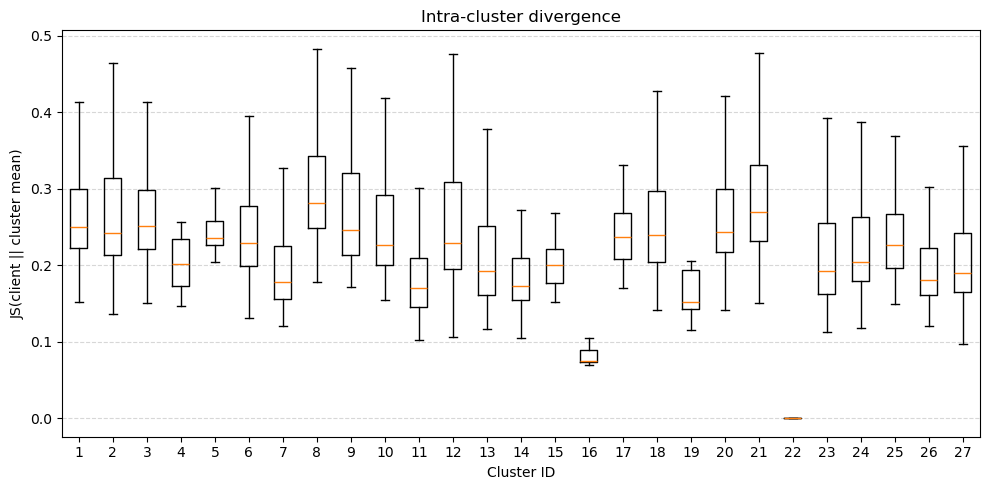

Mean / median JS per cluster:
  1: mean=0.275, median=0.251, n=1326
  2: mean=0.273, median=0.242, n=763
  3: mean=0.276, median=0.251, n=2018
  4: mean=0.221, median=0.201, n=17
  5: mean=0.251, median=0.236, n=9
  6: mean=0.254, median=0.229, n=841
  7: mean=0.208, median=0.179, n=62
  8: mean=0.303, median=0.281, n=485
  9: mean=0.271, median=0.246, n=48
  10: mean=0.249, median=0.226, n=108
  11: mean=0.199, median=0.171, n=216
  12: mean=0.260, median=0.229, n=1789
  13: mean=0.211, median=0.192, n=91
  14: mean=0.184, median=0.173, n=37
  15: mean=0.212, median=0.200, n=16
  16: mean=0.081, median=0.075, n=10
  17: mean=0.244, median=0.236, n=29
  18: mean=0.264, median=0.239, n=834
  19: mean=0.180, median=0.152, n=10
  20: mean=0.272, median=0.244, n=863
  21: mean=0.291, median=0.270, n=1082
  22: mean=0.000, median=0.000, n=1
  23: mean=0.227, median=0.193, n=404
  24: mean=0.240, median=0.204, n=671
  25: mean=0.250, median=0.226, n=538
  26: mean=0.214, median=0.181, n=71
 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

def js_divergence(p, q, eps=1e-12):
    p = np.maximum(p, eps); p /= p.sum()
    q = np.maximum(q, eps); q /= q.sum()
    m = 0.5*(p+q)
    def kl(a,b): return np.sum(a*(np.log(a)-np.log(b)))
    return 0.5*kl(p,m)+0.5*kl(q,m)

MAPPING_DIR   = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

df = pd.concat([pd.read_csv(MAPPING_DIR/"train.csv"),
                pd.read_csv(MAPPING_DIR/"validation.csv"),
                pd.read_csv(MAPPING_DIR/"test.csv")], ignore_index=True)

labels = sorted(df["label_name"].unique())
lid = {l:i for i,l in enumerate(labels)}
L = len(labels)

with open(CLUSTERS_JSON, "r") as f: clusters = json.load(f)
model_to_cluster = {m:c["id"] for c in clusters for m in c.get("models", [])}

with open(CLIENTS_PKL, "rb") as f: clients_obj = pickle.load(f)
entries = [(int(v["id"]), v["model"]) for v in (clients_obj.values() if isinstance(clients_obj, dict) else clients_obj)]
entries.sort(key=lambda t:t[0])
N = df["client_id"].max()+1
new2old = {i: entries[i][0] for i in range(N)}
old2model = dict(entries)
client_to_cluster = {i: model_to_cluster[old2model[new2old[i]]] for i in range(N) 
                     if old2model[new2old[i]] in model_to_cluster}

# Per-client distributions
g = df.groupby(["client_id","label_name"]).size().reset_index(name="cnt")
clients = sorted(g["client_id"].unique())
C = len(clients)
mat = np.zeros((C, L), dtype=float)
cid_index = {c:i for i,c in enumerate(clients)}
for _, row in g.iterrows():
    mat[cid_index[row["client_id"]], lid[row["label_name"]]] = row["cnt"]
mat = (mat.T / (mat.sum(axis=1)+1e-12)).T

# Cluster means and client->cluster mapping in matrix indexing
from collections import defaultdict
clus_to_idx = defaultdict(list)
for c in clients:
    if c in client_to_cluster:
        clus_to_idx[client_to_cluster[c]].append(cid_index[c])

# Compute JS(client || cluster_mean)
cluster_js = {}
for k, idxs in clus_to_idx.items():
    mean_k = mat[idxs].mean(axis=0)
    vals = [js_divergence(mat[i], mean_k) for i in idxs]
    cluster_js[k] = vals

# Plot box (or violin) across clusters
clusters_sorted = sorted(cluster_js.keys())
data = [cluster_js[k] for k in clusters_sorted]

plt.figure(figsize=(10,5))
plt.boxplot(data, labels=clusters_sorted, showfliers=False)
plt.xlabel("Cluster ID"); plt.ylabel("JS(client || cluster mean)")
plt.title("Intra-cluster divergence")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout(); plt.show()

# Summary
summ = {k: (np.mean(v), np.median(v)) for k,v in cluster_js.items()}
print("Mean / median JS per cluster:")
for k in clusters_sorted:
    m, md = summ[k]
    print(f"  {k}: mean={m:.3f}, median={md:.3f}, n={len(cluster_js[k])}")


In [ ]:
# import pandas as pd
# import numpy as np
# import json, pickle, math
# from pathlib import Path
# from collections import defaultdict, Counter
# from itertools import combinations

# # -----------------------------
# # Config
# # -----------------------------
# MAPPING_DIR   = Path("/Data/baptiste.geisenberger/Data/openImg/client_data_mapping")
# CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
# CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")
# CSV_FILES = {
#     "train": MAPPING_DIR / "train.csv",
#     "validation": MAPPING_DIR / "validation.csv",
#     "test": MAPPING_DIR / "test.csv",
# }
# # If you used fewer than all clients in clients.pkl, N is inferred from CSVs.

# # -----------------------------
# # Helpers
# # -----------------------------
# def js_divergence(p, q, eps=1e-12):
#     p = np.asarray(p, dtype=float)
#     q = np.asarray(q, dtype=float)
#     p = np.maximum(p, eps); p /= p.sum()
#     q = np.maximum(q, eps); q /= q.sum()
#     m = 0.5 * (p + q)
#     def kl(a, b):
#         return np.sum(a * (np.log(a) - np.log(b)))
#     return 0.5 * kl(p, m) + 0.5 * kl(q, m)

# def cosine_similarity(p, q, eps=1e-12):
#     p = np.asarray(p, float); q = np.asarray(q, float)
#     num = np.dot(p, q)
#     den = (np.linalg.norm(p) * np.linalg.norm(q)) + eps
#     return float(num / den)

# def gini_coefficient(x):
#     # x must be non-negative
#     x = np.asarray(x, dtype=float)
#     if np.all(x == 0): 
#         return 0.0
#     x = np.sort(x)
#     n = len(x)
#     cumx = np.cumsum(x)
#     gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
#     return float(gini)

# # -----------------------------
# # Load partition data
# # -----------------------------
# dfs = []
# for split, path in CSV_FILES.items():
#     df = pd.read_csv(path)
#     df["split"] = split
#     dfs.append(df)
# df = pd.concat(dfs, ignore_index=True)

# labels = sorted(df["label_name"].unique())
# label_to_id = {lab: i for i, lab in enumerate(labels)}
# num_labels = len(labels)

# # Determine N (new id space)
# observed_new_ids = sorted(df["client_id"].unique())
# N = int(max(observed_new_ids)) + 1

# # -----------------------------
# # Rebuild new_id -> cluster_id
# # -----------------------------
# with open(CLUSTERS_JSON, "r") as f:
#     clusters = json.load(f)
# model_to_cluster = {}
# for c in clusters:
#     for m in c.get("models", []):
#         if m in model_to_cluster and model_to_cluster[m] != c["id"]:
#             raise RuntimeError(f"Model '{m}' appears in multiple clusters; deduplicate clusters.json first.")
#         model_to_cluster[m] = c["id"]

# with open(CLIENTS_PKL, "rb") as f:
#     clients_obj = pickle.load(f)

# entries = []
# if isinstance(clients_obj, dict):
#     for v in clients_obj.values():
#         entries.append((int(v["id"]), v["model"]))
# elif isinstance(clients_obj, (list, tuple)):
#     for v in clients_obj:
#         entries.append((int(v["id"]), v["model"]))
# else:
#     raise TypeError(f"Unsupported clients.pkl type: {type(clients_obj)}")
# entries.sort(key=lambda t: t[0])

# if len(entries) < N:
#     raise RuntimeError(f"clients.pkl has {len(entries)} entries, but CSVs imply N={N} clients (0..{N-1}).")

# new2old = {i: entries[i][0] for i in range(N)}
# oldid_to_model = {old: model for (old, model) in entries}

# client_to_cluster = {}
# for new_id in observed_new_ids:
#     old_id = new2old[new_id]
#     model = oldid_to_model[old_id]
#     if model not in model_to_cluster:
#         raise RuntimeError(f"Model '{model}' (new_id {new_id}, old_id {old_id}) not in clusters.json")
#     client_to_cluster[new_id] = model_to_cluster[model]

# # -----------------------------
# # Build per-client label count vectors
# # -----------------------------
# # C x L matrix of counts (C=N clients, L labels)
# M_counts = np.zeros((N, num_labels), dtype=np.int64)
# client_has_data = np.zeros(N, dtype=bool)

# for _, row in df.iterrows():
#     cid = int(row["client_id"])
#     lid = label_to_id[row["label_name"]]
#     M_counts[cid, lid] += 1
#     client_has_data[cid] = True

# # Per-client total sizes
# client_sizes = M_counts.sum(axis=1)

# # Per-client label distributions (row-normalized)
# M_dist = M_counts.astype(float)
# row_sums = M_dist.sum(axis=1, keepdims=True) + 1e-12
# M_dist /= row_sums

# # -----------------------------
# # Group clients by cluster
# # -----------------------------
# cluster_to_clients = defaultdict(list)
# for cid, clus in client_to_cluster.items():
#     if client_has_data[cid]:
#         cluster_to_clients[clus].append(cid)

# clusters_sorted = sorted(cluster_to_clients.keys())

# # -----------------------------
# # Intra-cluster metrics
# # -----------------------------
# intra_rows = []
# for clus in clusters_sorted:
#     cids = cluster_to_clients[clus]
#     if len(cids) == 0:
#         continue
#     # Client sizes
#     sizes = client_sizes[cids]
#     gini = gini_coefficient(sizes)
#     cov  = float(np.std(sizes) / (np.mean(sizes) + 1e-12))

#     # Pairwise JS & cosine on distributions
#     dists = M_dist[cids]
#     js_vals = []
#     cos_vals = []
#     # For large clusters, sample pairs to keep it fast
#     MAX_PAIRS = 20000
#     all_pairs = list(combinations(range(len(cids)), 2))
#     if len(all_pairs) > MAX_PAIRS:
#         idxs = np.random.choice(len(all_pairs), size=MAX_PAIRS, replace=False)
#         pairs = [all_pairs[i] for i in idxs]
#     else:
#         pairs = all_pairs

#     for a, b in pairs:
#         pa = dists[a]; pb = dists[b]
#         js_vals.append(js_divergence(pa, pb))
#         cos_vals.append(cosine_similarity(pa, pb))

#     js_vals = np.array(js_vals) if js_vals else np.array([0.0])
#     cos_vals = np.array(cos_vals) if cos_vals else np.array([1.0])

#     intra_rows.append({
#         "cluster_id": clus,
#         "num_clients": len(cids),
#         "total_samples": int(sizes.sum()),
#         "client_size_mean": float(np.mean(sizes)),
#         "client_size_std": float(np.std(sizes)),
#         "client_size_cov": cov,
#         "client_size_gini": gini,
#         "intra_JS_mean": float(np.mean(js_vals)),
#         "intra_JS_median": float(np.median(js_vals)),
#         "intra_cosine_mean": float(np.mean(cos_vals)),
#         "intra_cosine_median": float(np.median(cos_vals)),
#     })

# intra_df = pd.DataFrame(intra_rows).sort_values("cluster_id").reset_index(drop=True)
# display(intra_df)

# # -----------------------------
# # Inter-cluster metrics
# # -----------------------------
# # Cluster-level distributions P_k
# cluster_P = {}
# for clus in clusters_sorted:
#     cids = cluster_to_clients[clus]
#     # Sum counts over clients in cluster, then normalize
#     vec = M_counts[cids].sum(axis=0).astype(float)
#     if vec.sum() == 0:
#         Pk = np.zeros_like(vec)
#     else:
#         Pk = vec / vec.sum()
#     cluster_P[clus] = Pk

# # Pairwise JS between clusters
# clus_pairs = list(combinations(clusters_sorted, 2))
# pair_rows = []
# for a, b in clus_pairs:
#     pa = cluster_P[a]; pb = cluster_P[b]
#     js = js_divergence(pa, pb)
#     pair_rows.append({"cluster_a": a, "cluster_b": b, "JS": float(js)})

# inter_df = pd.DataFrame(pair_rows)
# if not inter_df.empty:
#     # Summary
#     inter_summary = {
#         "num_pairs": len(inter_df),
#         "JS_mean": float(inter_df["JS"].mean()),
#         "JS_median": float(inter_df["JS"].median()),
#         "JS_min": float(inter_df["JS"].min()),
#         "JS_max": float(inter_df["JS"].max()),
#     }
#     print("\nInter-cluster JS divergence summary:", inter_summary)

#     # Nearest/farthest pairs
#     k = min(10, len(inter_df))
#     print("\nClosest clusters (lowest JS):")
#     display(inter_df.nsmallest(k, "JS").reset_index(drop=True))
#     print("\nMost different clusters (highest JS):")
#     display(inter_df.nlargest(k, "JS").reset_index(drop=True))

#     # Optional: full matrix (as DataFrame)
#     # Build symmetric matrix for convenience
#     clus_idx = {c: i for i, c in enumerate(clusters_sorted)}
#     mat = np.zeros((len(clusters_sorted), len(clusters_sorted)))
#     for _, row in inter_df.iterrows():
#         i = clus_idx[row["cluster_a"]]; j = clus_idx[row["cluster_b"]]
#         mat[i, j] = mat[j, i] = row["JS"]
#     inter_mat_df = pd.DataFrame(mat, index=clusters_sorted, columns=clusters_sorted)
#     print("\nInter-cluster JS divergence matrix (symmetric, 0 on diagonal):")
#     display(inter_mat_df)
# else:
#     print("Not enough clusters with data to compute inter-cluster metrics.")

## Utils

In [ ]:
import json
from collections import Counter

CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")

with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)

all_models = []
for c in clusters:
    cid = c.get("id", None)
    models = c.get("models", [])
    for m in models:
        all_models.append((m, cid))

# Count model occurrences
model_counts = Counter([m for m, _ in all_models])
dupes = {m: count for m, count in model_counts.items() if count > 1}

if not dupes:
    print("✅ No duplicate model strings found in any cluster.")
else:
    print(f"⚠️ Found {len(dupes)} duplicate model strings across clusters.\n")
    for m, count in dupes.items():
        cluster_ids = [cid for mm, cid in all_models if mm == m]
        print(f"Model '{m}' appears {count} times in clusters: {cluster_ids}")


⚠️ Found 32 duplicate model strings across clusters.

Model 'Galaxy S5 Neo' appears 2 times in clusters: [1, 1]
Model 'I9506 Galaxy S4' appears 4 times in clusters: [1, 1, 1, 1]
Model 'Galaxy Note 3' appears 6 times in clusters: [1, 1, 1, 1, 1, 1]
Model 'I9505 Galaxy S4' appears 2 times in clusters: [1, 1]
Model 'I9500 Galaxy S4' appears 3 times in clusters: [1, 1, 1]
Model 'Xperia Z1' appears 2 times in clusters: [1, 1]
Model 'Xperia Z' appears 2 times in clusters: [1, 1]
Model 'Moto G' appears 3 times in clusters: [2, 2, 2]
Model 'Moto X' appears 3 times in clusters: [2, 2, 2]
Model 'Galaxy J7' appears 2 times in clusters: [3, 3]
Model 'I9305 Galaxy S III' appears 2 times in clusters: [3, 3]
Model 'Galaxy Note II CDMA' appears 4 times in clusters: [3, 3, 3, 3]
Model 'Galaxy S III I747' appears 3 times in clusters: [3, 3, 3]
Model 'IdeaTab A3000' appears 2 times in clusters: [6, 6]
Model 'One' appears 3 times in clusters: [8, 8, 20]
Model 'Galaxy J5' appears 2 times in clusters: [12, 

In [6]:
import json
import time
from pathlib import Path
from collections import defaultdict, Counter

# -------- CONFIG (you must choose) --------
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
KEEP_POLICY = "first"  # <-- REQUIRED: set to one of: "first", "highest_rank", "lowest_rank", "smallest_cluster"
DRY_RUN = False      # True -> only report; False -> write changes (with backup)

# ------------------------------------------

if KEEP_POLICY not in {"first", "highest_rank", "lowest_rank", "smallest_cluster"}:
    raise ValueError("Please set KEEP_POLICY to one of: 'first', 'highest_rank', 'lowest_rank', 'smallest_cluster'.")

# Load clusters
with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)

# Normalize & verify structure
for idx, c in enumerate(clusters):
    if "id" not in c or "models" not in c:
        raise ValueError(f"Cluster at index {idx} missing 'id' or 'models'. Entry: {c}")
    if not isinstance(c["models"], list):
        raise TypeError(f"Cluster id={c['id']} has non-list 'models'.")
    if "rank" not in c:
        # If rank is missing, treat as 0 for ranking-based policies
        c["rank"] = 0

# Prepare helpers
cluster_index_by_id = {c["id"]: i for i, c in enumerate(clusters)}
cluster_sizes = {c["id"]: len(c["models"]) for c in clusters}

# Collect occurrences: model -> list of (cluster_id, rank, cluster_file_index, position_in_models_list)
occ = defaultdict(list)
for c_idx, c in enumerate(clusters):
    cid = c["id"]
    crank = c.get("rank", 0)
    for pos, m in enumerate(c["models"]):
        occ[m].append((cid, crank, c_idx, pos))

# Determine duplicates
dupe_models = {m: lst for m, lst in occ.items() if len(lst) > 1}
print(f"Found {len(dupe_models)} models that appear in multiple clusters.")

def choose_winner(model, entries):
    """
    entries: list of tuples (cluster_id, rank, cluster_file_index, pos_in_list)
    Returns winning (cluster_id, rank, cluster_file_index, pos_in_list)
    """
    if KEEP_POLICY == "first":
        # first by file order (cluster_file_index), then position
        return sorted(entries, key=lambda t: (t[2], t[3]))[0]
    elif KEEP_POLICY == "highest_rank":
        # highest rank wins; tie-breaker: first by file order, then pos
        return sorted(entries, key=lambda t: (-t[1], t[2], t[3]))[0]
    elif KEEP_POLICY == "lowest_rank":
        # lowest rank wins; tie-breaker: first by file order, then pos
        return sorted(entries, key=lambda t: (t[1], t[2], t[3]))[0]
    elif KEEP_POLICY == "smallest_cluster":
        # smallest cluster size wins; tie-breakers: first by file order, then pos
        return sorted(entries, key=lambda t: (cluster_sizes.get(t[0], 10**9), t[2], t[3]))[0]
    else:
        raise RuntimeError("Unreachable: invalid KEEP_POLICY")

# Compute removals
removals = defaultdict(list)  # cluster_id -> list of models to remove
kept = {}                     # model -> cluster_id
for m, entries in dupe_models.items():
    win = choose_winner(m, entries)
    win_cid = win[0]
    kept[m] = win_cid
    for (cid, _, _, _) in entries:
        if cid != win_cid:
            removals[cid].append(m)

# Report plan
total_removals = sum(len(v) for v in removals.values())
print(f"\nPlanned removals: {total_removals} duplicate occurrences across {len([k for k,v in removals.items() if v])} clusters.")
preview_limit = 10
shown = 0
for cid, mods in removals.items():
    if not mods:
        continue
    to_show = mods[:max(0, preview_limit - shown)]
    if to_show:
        print(f" - Cluster {cid}: remove {len(mods)} models (showing {len(to_show)}): {to_show}")
        shown += len(to_show)
    if shown >= preview_limit:
        break

# Apply (if not dry run)
if not DRY_RUN and total_removals > 0:
    # Create backup
    ts = time.strftime("%Y%m%d-%H%M%S")
    backup_path = CLUSTERS_JSON.with_suffix(f".backup.{ts}.json")
    with open(backup_path, "w") as bf:
        json.dump(clusters, bf, indent=2, ensure_ascii=False)
    print(f"\nBackup created at: {backup_path}")

    # Build new clusters with removals applied
    cid_to_idx = {c["id"]: i for i, c in enumerate(clusters)}
    for cid, mods in removals.items():
        cidx = cid_to_idx[cid]
        before = len(clusters[cidx]["models"])
        # Remove while preserving order
        mods_set = set(mods)
        clusters[cidx]["models"] = [m for m in clusters[cidx]["models"] if m not in mods_set]
        after = len(clusters[cidx]["models"])
        assert after <= before
        cluster_sizes[cid] = after

    # Save back in place
    with open(CLUSTERS_JSON, "w") as f:
        json.dump(clusters, f, indent=2, ensure_ascii=False)
    print(f"✅ clusters.json updated in place. Removed {total_removals} duplicate occurrences.")

elif DRY_RUN:
    print("\n(DRY_RUN=True) No changes written. Set DRY_RUN=False to apply.")
else:
    print("\nNo duplicates to remove. File left unchanged.")

Found 31 models that appear in multiple clusters.

Planned removals: 0 duplicate occurrences across 0 clusters.

No duplicates to remove. File left unchanged.


In [10]:
import pickle
from pathlib import Path

CLIENTS_PKL = Path("../benchmark/dataset/data/clients.pkl")

with open(CLIENTS_PKL, "rb") as f:
    clients_obj = pickle.load(f)

# Extract ids depending on structure
ids = []
if isinstance(clients_obj, dict):
    for v in clients_obj.values():
        if "id" not in v:
            raise RuntimeError("Missing 'id' field in a client entry.")
        ids.append(int(v["id"]))
elif isinstance(clients_obj, (list, tuple)):
    for v in clients_obj:
        ids.append(int(v["id"]))
else:
    raise TypeError(f"Unsupported clients.pkl type: {type(clients_obj)}")

ids = sorted(ids)
n = len(ids)

print(f"Loaded {n} client entries.")
print(f"Min id = {ids[0]}, Max id = {ids[-1]}")

expected = list(range(ids[0], ids[-1] + 1))
if ids == expected:
    print("✅ IDs are contiguous with no duplicates.")
else:
    missing = sorted(set(expected) - set(ids))
    duplicates = [x for x in ids if ids.count(x) > 1]
    print("❌ IDs are not contiguous or contain duplicates.")
    if missing:
        print(f"  Missing {len(missing)} ids, first few: {missing[:20]}")
    if duplicates:
        print(f"  Duplicate ids found: {set(duplicates)}")


Loaded 12641 client entries.
Min id = 1, Max id = 12641
✅ IDs are contiguous with no duplicates.


In [11]:
import pickle, time
from pathlib import Path

CLIENTS_PKL = Path("../benchmark/dataset/data/clients.pkl")

# 1) Load
with open(CLIENTS_PKL, "rb") as f:
    clients_obj = pickle.load(f)

# 2) Shift IDs
def shift_id(obj):
    if isinstance(obj, dict):
        for v in obj.values():
            if "id" not in v:
                raise RuntimeError("Missing 'id' field in a client entry.")
            v["id"] = int(v["id"]) - 1
    elif isinstance(obj, (list, tuple)):
        for v in obj:
            v["id"] = int(v["id"]) - 1
    else:
        raise TypeError(f"Unsupported clients.pkl type: {type(obj)}")
    return obj

clients_obj = shift_id(clients_obj)

# 3) Verify contiguous 0..12640 with no duplicates
ids = []
if isinstance(clients_obj, dict):
    ids = [int(v["id"]) for v in clients_obj.values()]
else:
    ids = [int(v["id"]) for v in clients_obj]

ids_sorted = sorted(ids)
expected = list(range(0, 12641))  # 0..12640 inclusive

if ids_sorted != expected:
    raise RuntimeError("After shifting, IDs are not contiguous 0..12640.")

print("✅ Verified: IDs now span 0..12640 with no duplicates.")

# 4) Backup original
ts = time.strftime("%Y%m%d-%H%M%S")
backup_path = CLIENTS_PKL.with_suffix(f".backup.{ts}.pkl")
with open(backup_path, "wb") as f:
    pickle.dump(clients_obj, f)
print(f"Backup of modified object written to: {backup_path}")

# 5) Overwrite original file
with open(CLIENTS_PKL, "wb") as f:
    pickle.dump(clients_obj, f)
print(f"✅ Overwrote {CLIENTS_PKL} with shifted IDs.")


✅ Verified: IDs now span 0..12640 with no duplicates.
Backup of modified object written to: ../benchmark/dataset/data/clients.backup.20250909-143015.pkl
✅ Overwrote ../benchmark/dataset/data/clients.pkl with shifted IDs.
